# DX 704 Week 2 Project

This week's project will analyze fresh strawberry price data for a hypothetical "buy low, freeze, and sell high" business.
Strawberries show strong seasonality in their prices compared to other fruits.

![](https://ers.usda.gov/sites/default/files/_laserfiche/Charts/61401/oct14_finding_plattner_fig01.png)

Image source: https://www.ers.usda.gov/amber-waves/2014/october/seasonal-fresh-fruit-price-patterns-differ-across-commodities-the-case-of-strawberries-and-apples

You are considering a business where you buy strawberries when the prices are very low, carefully freeze them, even more carefully defrost them, and then sell them when the prices are high.
You will forecast strawberry price time series and then use them to tactically pick times to buy, freeze, and sell the strawberries.

The full project description, a template notebook, and raw data are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-02


### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Backtest Strawberry Prices

Read the provided "strawberry-prices.tsv" with data from 2000 through 2024.
This data is based on data from the U.S. Bureau of Statistics, but transformed so the ground truth is not online.
https://fred.stlouisfed.org/series/APU0000711415

Use the data for 2000 through 2023 to predict monthly prices in 2024.
Spend some time to make sure you are happy with your methodology and prediction accuracy, since you will reuse the methodology to forecast 2025 next.
Save the 2024 backtest predictions as "strawberry-backtest.tsv" with columns month and price.


In [1]:
# %pip install prophet --quiet

In [2]:
# YOUR CHANGES HERE

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa.ar_model as ar_model
import statsmodels.graphics.tsaplots as tsaplots

import logging
import time
from datetime import datetime, timedelta
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import scipy.stats

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures

# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# from sklearn.model_selection import cross_val_score

# Import strawberry-prices.tsv
strawberry_prices = pd.read_csv("strawberry-prices.tsv", sep="\t")
strawberry_prices["month"] = pd.to_datetime(strawberry_prices["month"])
strawberry_prices = strawberry_prices[strawberry_prices["month"] < "2024-01-01"]
strawberry_prices = strawberry_prices.set_index("month")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


<Axes: xlabel='month'>

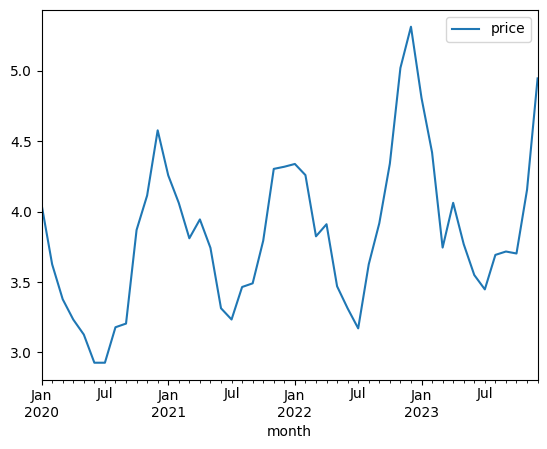

In [3]:
strawberry_prices.plot()

In [4]:
strawberry_prices.head()

,price
month,
2020-01-01,4.0490
2020-02-01,3.6250
2020-03-01,3.3770
2020-04-01,3.2328
2020-05-01,3.1260


In [5]:
strawberry_prices_length = len(strawberry_prices)

In [6]:
strawberry_prices["price"].autocorr(lag=12)

np.float64(0.7629619472455611)

### 1. Statsmodel

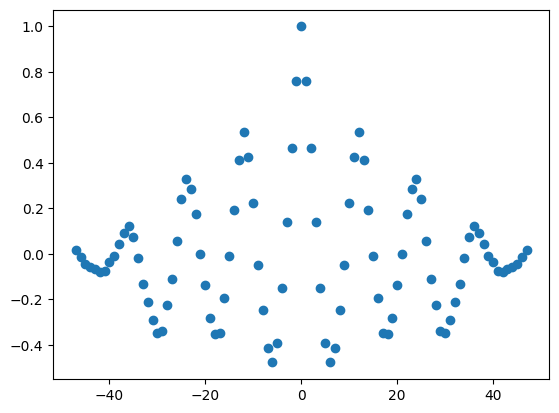

In [7]:
# Correlogram
plt.acorr(strawberry_prices["price"] - strawberry_prices["price"].mean(), normed=True, maxlags=(strawberry_prices_length - 1), usevlines=False);

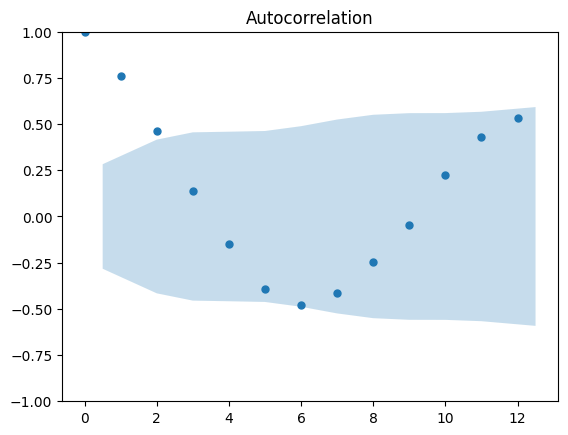

In [8]:
# One year
tsaplots.plot_acf(strawberry_prices["price"], lags=12, use_vlines=False);

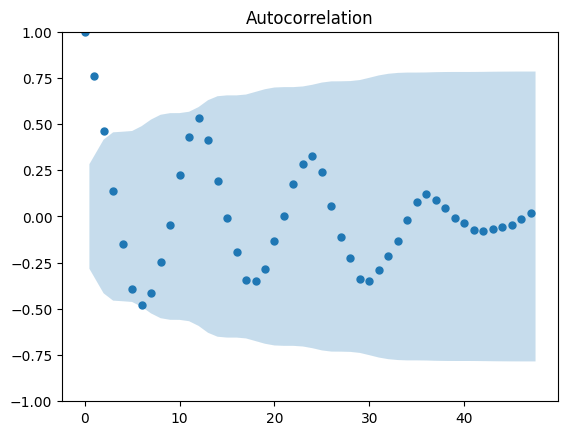

In [9]:
# Five years
tsaplots.plot_acf(strawberry_prices["price"], lags=(strawberry_prices_length - 1), use_vlines=False);

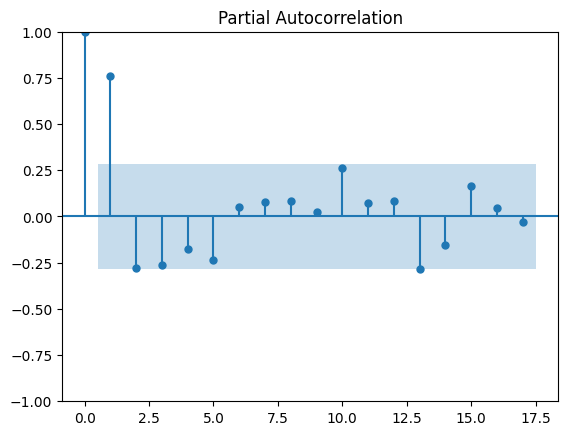

In [10]:
tsaplots.plot_pacf(strawberry_prices["price"]);

In [11]:
strawberry_prices.index.freq = "MS"

In [12]:
mod_1 = ar_model.AutoReg(strawberry_prices["price"], 
                         lags=1, 
                         period=36, 
                         seasonal=True)

res_1 = mod_1.fit()

In [13]:
p_1 = res_1.predict(strawberry_prices_length, strawberry_prices_length*2)
p_1

2024-01-01    4.550599
2024-02-01    4.294605
2024-03-01    3.995870
2024-04-01    4.091889
2024-05-01    3.859670
2024-06-01    3.406625
2024-07-01    3.307494
2024-08-01    3.523272
2024-09-01    3.537160
2024-10-01    3.830523
2024-11-01    4.332856
2024-12-01    4.342055
2025-01-01    4.356901
2025-02-01    4.274039
2025-03-01    3.835966
2025-04-01    3.919521
2025-05-01    3.476575
2025-06-01    3.318027
2025-07-01    3.174796
2025-08-01    3.628816
2025-09-01    3.920036
2025-10-01    4.342416
2025-11-01    5.021922
2025-12-01    5.314529
2026-01-01    4.808217
2026-02-01    4.325023
2026-03-01    3.801206
2026-04-01    3.838920
2026-05-01    3.599385
2026-06-01    3.358746
2026-07-01    3.282971
2026-08-01    3.511758
2026-09-01    3.521073
2026-10-01    3.834094
2026-11-01    4.173164
2026-12-01    4.792263
2027-01-01    4.428277
2027-02-01    4.197278
2027-03-01    3.918431
2027-04-01    4.030274
2027-05-01    3.810645
2027-06-01    3.367618
2027-07-01    3.276457
2027-08-01 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:735: RuntimeWarning: divide by zero encountered in matmul
  in_sample = x @ params
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:735: RuntimeWarning: overflow encountered in matmul
  in_sample = x @ params
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:735: RuntimeWarning: invalid value encountered in matmul
  in_sample = x @ params
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:735: RuntimeWarning: divide by zero encountered in matmul
  in_sample = x @ params
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/ar_model.py:735: RuntimeWarning: overflow encountered in matmul
  in_sample = x @ params
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyt

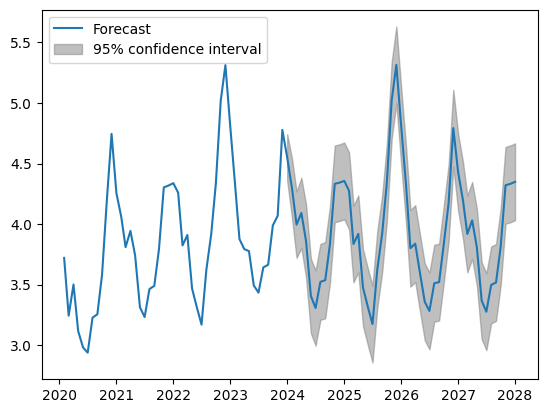

In [14]:
fig_1 = res_1.plot_predict(0, strawberry_prices_length*2)

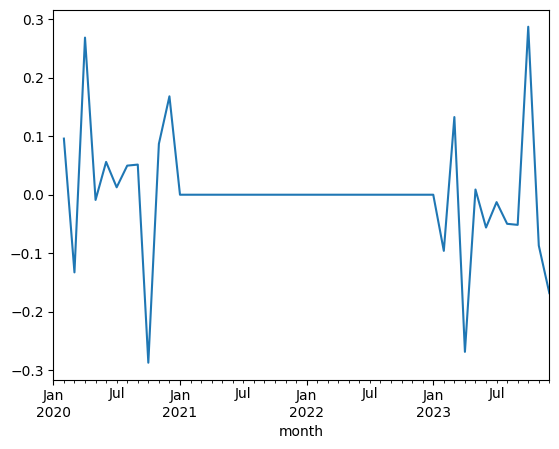

In [15]:
strawberry_prices["predicted"] = res_1.predict(0, strawberry_prices_length - 1)
(strawberry_prices["predicted"] - strawberry_prices["price"]).plot();

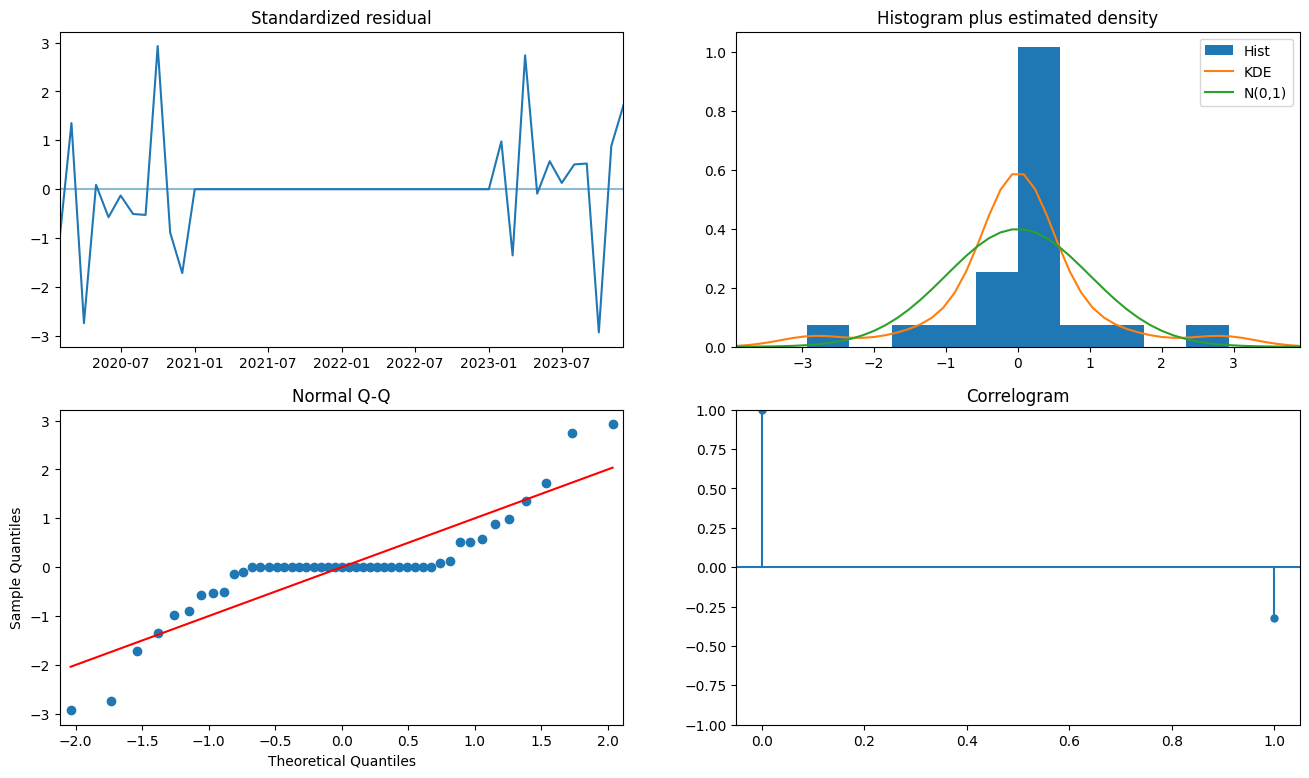

In [16]:
fig_1 = plt.figure(figsize=(16, 9))
fig_1 = res_1.plot_diagnostics(fig=fig_1, lags=1)

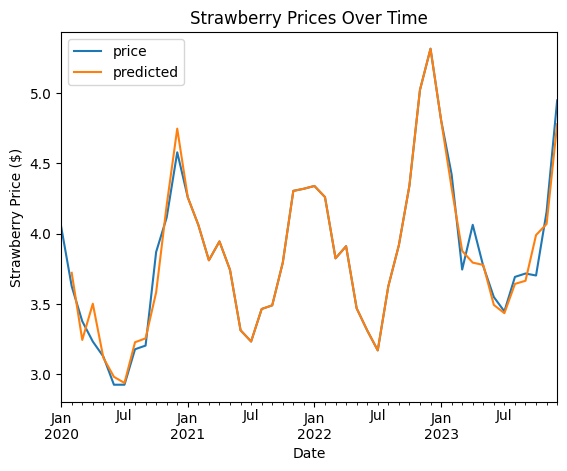

In [17]:
strawberry_prices.plot();
plt.title("Strawberry Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Strawberry Price ($)")
plt.show()

### 2. Facebook Prophet (With Weekly Component)

In [18]:
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Strawberry Prices
strawberry_prices_2 = pd.read_csv("strawberry-prices.tsv", sep="\t")
strawberry_prices_2["month"] = pd.to_datetime(strawberry_prices_2["month"])
strawberry_prices_2 = strawberry_prices_2[strawberry_prices_2["month"] < "2024-01-01"]
strawberry_prices_2 = strawberry_prices_2.rename(mapper={"month": "ds", "price": "y"}, axis=1)
strawberry_prices_2.head()

,ds,y
0,2020-01-01,4.0490
1,2020-02-01,3.6250
2,2020-03-01,3.3770
3,2020-04-01,3.2328
4,2020-05-01,3.1260


In [19]:
strawberry_prices_length = len(strawberry_prices_2)
strawberry_prices_length

48

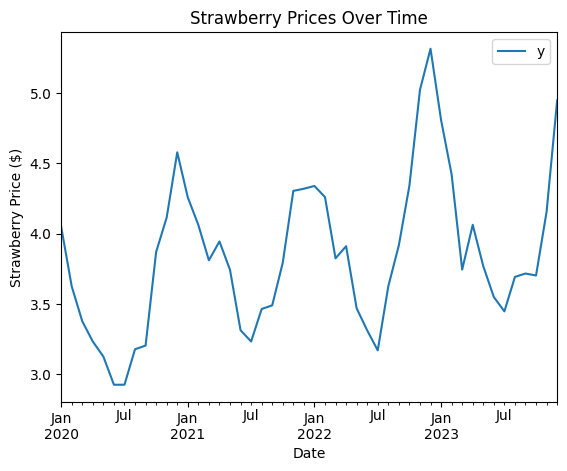

In [20]:
strawberry_prices_2.set_index("ds").plot();
plt.title("Strawberry Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Strawberry Price ($)")
plt.show()

In [21]:
mod_2 = Prophet()
mod_2.fit(strawberry_prices_2)

In [22]:
mod_2_future = mod_2.make_future_dataframe(periods=12, freq="MS")
mod_2_forecast = mod_2.predict(mod_2_future)
mod_2_forecast

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1562: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1562: RuntimeWarning: overflow encountered in matmul
  Xb_a = np.matmul(seasonal_features.

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,3.447420,3.894682,4.269174,3.447420,3.447420,0.645035,0.645035,0.645035,0.645035,0.645035,0.645035,0.0,0.0,0.0,4.092455
1,2020-02-01,3.468204,3.514688,3.879803,3.468204,3.468204,0.224922,0.224922,0.224922,0.224922,0.224922,0.224922,0.0,0.0,0.0,3.693125
2,2020-03-01,3.487647,3.256239,3.657900,3.487647,3.487647,-0.018070,-0.018070,-0.018070,-0.018070,-0.018070,-0.018070,0.0,0.0,0.0,3.469577
3,2020-04-01,3.508431,3.162629,3.558661,3.508431,3.508431,-0.140669,-0.140669,-0.140669,-0.140669,-0.140669,-0.140669,0.0,0.0,0.0,3.367762
4,2020-05-01,3.528544,3.029349,3.427483,3.528544,3.528544,-0.302393,-0.302393,-0.302393,-0.302393,-0.302393,-0.302393,0.0,0.0,0.0,3.226152
5,2020-06-01,3.549328,2.763474,3.138826,3.549328,3.549328,-0.607465,-0.607465,-0.607465,-0.607465,-0.607465,-0.607465,0.0,0.0,0.0,2.941864
6,2020-07-01,3.569442,2.726875,3.099435,3.569442,3.569442,-0.656100,-0.656100,-0.656100,-0.656100,-0.656100,-0.656100,0.0,0.0,0.0,2.913342
7,2020-08-01,3.590226,2.972764,3.363417,3.590226,3.590226,-0.416489,-0.416489,-0.416489,-0.416489,-0.416489,-0.416489,0.0,0.0,0.0,3.173737
8,2020-09-01,3.611009,3.019826,3.425622,3.611009,3.611009,-0.391787,-0.391787,-0.391787,-0.391787,-0.391787,-0.391787,0.0,0.0,0.0,3.219222
9,2020-10-01,3.631121,3.651630,4.051385,3.631121,3.631121,0.211595,0.211595,0.211595,0.211595,0.211595,0.211595,0.0,0.0,0.0,3.842716


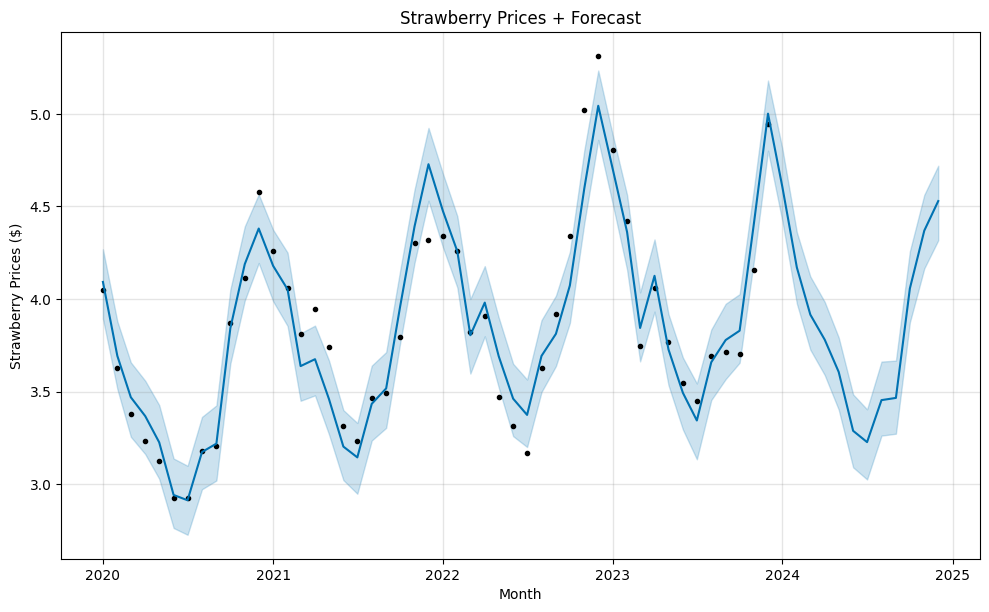

In [23]:
mod_2.plot(mod_2_forecast)

plt.title("Strawberry Prices + Forecast")
plt.xlabel("Month")
plt.ylabel("Strawberry Prices ($)")
plt.plot();

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())


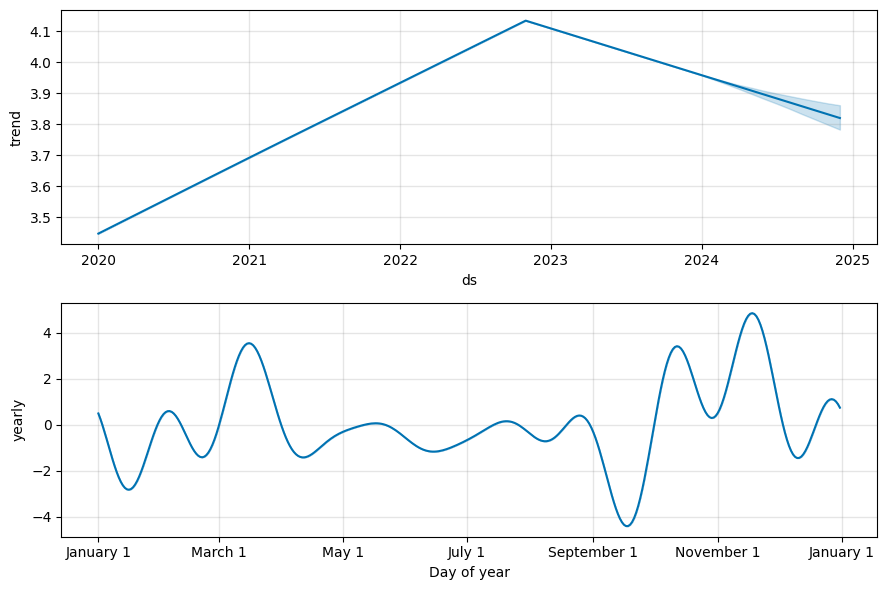

In [24]:
mod_2.plot_components(mod_2_forecast);

In [25]:
strawberry_price_data_1 = (
    mod_2_forecast
        .rename(columns={"ds": "month", "yhat": "price"})[["month", "price"]]
        .reset_index(drop=True)
)

strawberry_backtest = strawberry_price_data_1[strawberry_price_data_1["month"] > "2023-12-01"].reset_index(drop=True)
strawberry_backtest

,month,price
0,2024-01-01,4.603632
1,2024-02-01,4.170715
2,2024-03-01,3.915747
3,2024-04-01,3.780345
4,2024-05-01,3.606231
5,2024-06-01,3.288356
6,2024-07-01,3.227331
7,2024-08-01,3.454139
8,2024-09-01,3.466038
9,2024-10-01,4.057030


In [26]:
strawberry_backtest.to_csv("strawberry-backtest.tsv", sep="\t", index=False)

Submit "strawberry-backtest.tsv" in Gradescope.

## Part 2: Backtest Errors

What are the mean and standard deviation of the residuals between your backtest predictions and the ground truth? (If your mean is not close to zero, then you may be missing a long term trend.)

Write the mean and standard deviation to a file "backtest-accuracy.tsv" with two columns, mean and std.

In [27]:
# YOUR CHANGES HERE

strawberry_prices_2024 = pd.read_csv("strawberry-prices.tsv", sep="\t")
strawberry_prices_2024["month"] = pd.to_datetime(strawberry_prices_2024["month"])
strawberry_prices_2024 = strawberry_prices_2024[strawberry_prices_2024["month"] > "2023-12-01"]
strawberry_prices_2024 = strawberry_prices_2024.reset_index(drop=True)

In [28]:
strawberry_prices_2024["price"]

0     5.055
1     4.264
2     3.742
3     3.576
4     3.237
5     2.977
6     3.116
7     3.347
8     3.742
9     3.718
10    4.420
11    4.857
Name: price, dtype: float64

In [29]:
strawberry_backtest["price"]

0     4.603632
1     4.170715
2     3.915747
3     3.780345
4     3.606231
5     3.288356
6     3.227331
7     3.454139
8     3.466038
9     4.057030
10    4.369473
11    4.529240
Name: price, dtype: float64

In [30]:
strawberry_prices_residuals = strawberry_prices_2024["price"] - strawberry_backtest["price"]
strawberry_prices_residuals

0     0.451368
1     0.093285
2    -0.173747
3    -0.204345
4    -0.369231
5    -0.311356
6    -0.111331
7    -0.107139
8     0.275962
9    -0.339030
10    0.050527
11    0.327760
Name: price, dtype: float64

In [31]:
residuals_mean = strawberry_prices_residuals.mean()
residuals_std = strawberry_prices_residuals.std()
print(residuals_mean, residuals_std)

-0.03477319040018911 0.27437435887801676


In [32]:
backtest_accuracy = pd.DataFrame({"mean": [residuals_mean], "std": [residuals_std]})
backtest_accuracy

,mean,std
0,-0.034773,0.274374


In [33]:
backtest_accuracy.to_csv("backtest-accuracy.tsv", sep="\t", index=False)

Submit "backtest-accuracy.tsv" in Gradescope.

## Part 3: Forecast Strawberry Prices

Use all the data from 2000 through 2024 to predict monthly prices in 2025 using the same methodology from part 1.
Make a monthly forecast for each month of 2025 and save it as "strawberry-forecast.tsv" with columns for month and price.

In [34]:
# YOUR CHANGES HERE

# Strawberry Prices
strawberry_prices_3 = pd.read_csv("strawberry-prices.tsv", sep="\t")
strawberry_prices_3["month"] = pd.to_datetime(strawberry_prices_3["month"])
strawberry_prices_3 = strawberry_prices_3[strawberry_prices_3["month"] < "2025-01-01"]
strawberry_prices_3 = strawberry_prices_3.rename(mapper={"month": "ds", "price": "y"}, axis=1)
strawberry_prices_3.head()

,ds,y
0,2020-01-01,4.0490
1,2020-02-01,3.6250
2,2020-03-01,3.3770
3,2020-04-01,3.2328
4,2020-05-01,3.1260


In [35]:
strawberry_prices_length = len(strawberry_prices_3)
strawberry_prices_length

60

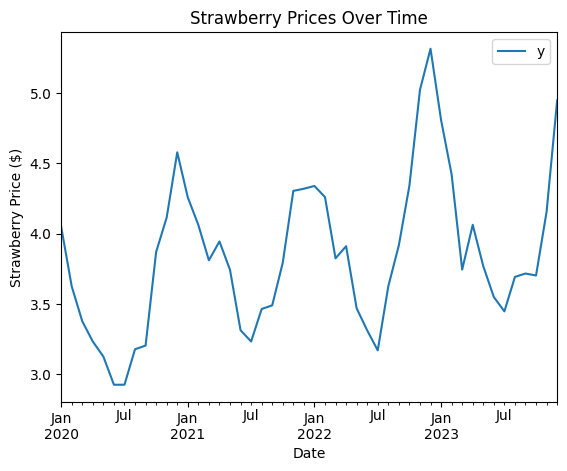

In [36]:
strawberry_prices_2.set_index("ds").plot();
plt.title("Strawberry Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Strawberry Price ($)")
plt.show()

In [37]:
mod_3 = Prophet()
mod_3.fit(strawberry_prices_3)

In [38]:
mod_3_future = mod_3.make_future_dataframe(periods=12, freq="MS")
mod_3_forecast = mod_3.predict(mod_3_future)
mod_3_forecast

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1562: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1562: RuntimeWarning: overflow encountered in matmul
  Xb_a = np.matmul(seasonal_features.

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,3.447080,4.058753,4.472592,3.447080,3.447080,0.825011,0.825011,0.825011,0.825011,0.825011,0.825011,0.0,0.0,0.0,4.272091
1,2020-02-01,3.468045,3.491611,3.921287,3.468045,3.468045,0.236370,0.236370,0.236370,0.236370,0.236370,0.236370,0.0,0.0,0.0,3.704415
2,2020-03-01,3.487658,3.251362,3.673731,3.487658,3.487658,-0.027653,-0.027653,-0.027653,-0.027653,-0.027653,-0.027653,0.0,0.0,0.0,3.460006
3,2020-04-01,3.508624,3.143369,3.555315,3.508624,3.508624,-0.158831,-0.158831,-0.158831,-0.158831,-0.158831,-0.158831,0.0,0.0,0.0,3.349793
4,2020-05-01,3.528914,2.931464,3.338651,3.528914,3.528914,-0.390460,-0.390460,-0.390460,-0.390460,-0.390460,-0.390460,0.0,0.0,0.0,3.138453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2025-08-01,3.675636,3.032345,3.481738,3.656978,3.695099,-0.412384,-0.412384,-0.412384,-0.412384,-0.412384,-0.412384,0.0,0.0,0.0,3.263252
68,2025-09-01,3.661573,3.192487,3.619593,3.639700,3.684947,-0.261694,-0.261694,-0.261694,-0.261694,-0.261694,-0.261694,0.0,0.0,0.0,3.399879
69,2025-10-01,3.647964,3.456899,3.880298,3.622518,3.674911,0.015002,0.015002,0.015002,0.015002,0.015002,0.015002,0.0,0.0,0.0,3.662965
70,2025-11-01,3.633901,3.933722,4.364379,3.603930,3.664999,0.520802,0.520802,0.520802,0.520802,0.520802,0.520802,0.0,0.0,0.0,4.154703


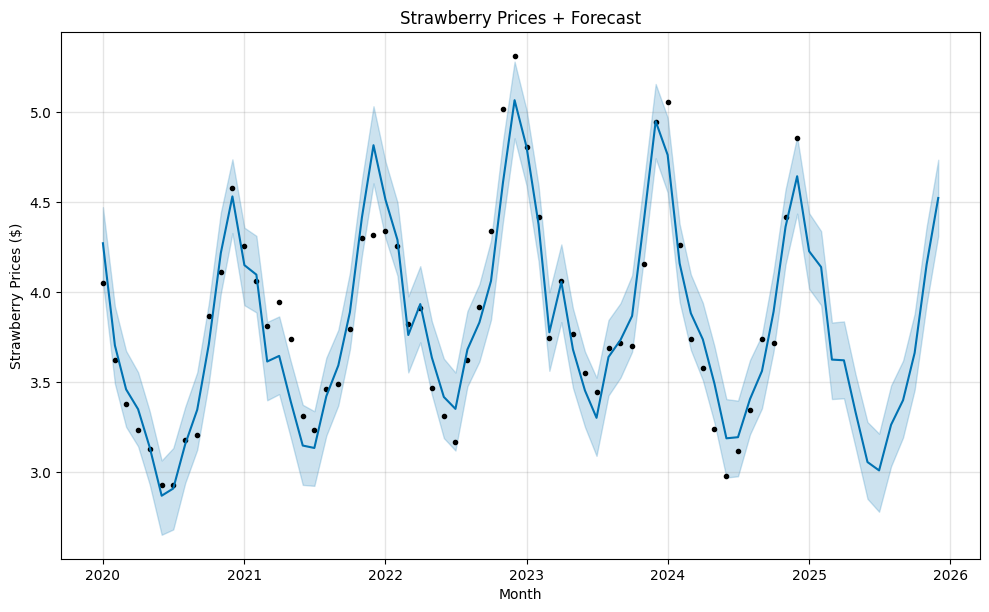

In [39]:
mod_3.plot(mod_3_forecast)

plt.title("Strawberry Prices + Forecast")
plt.xlabel("Month")
plt.ylabel("Strawberry Prices ($)")
plt.plot();

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())


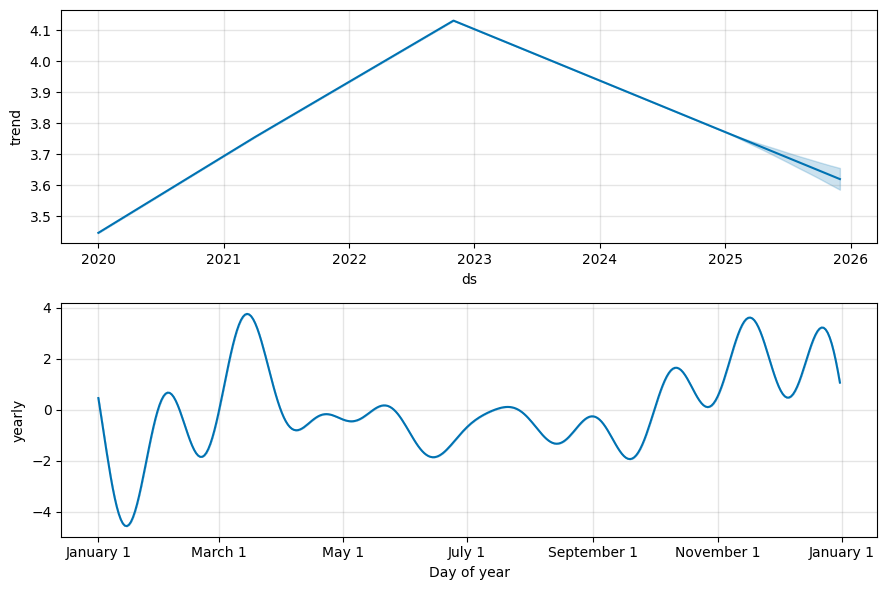

In [40]:
mod_3.plot_components(mod_3_forecast);

In [41]:
strawberry_price_data_2 = (
    mod_3_forecast
        .rename(columns={"ds": "month", "yhat": "price"})[["month", "price"]]
        .reset_index(drop=True)
)

strawberry_forecast = strawberry_price_data_2[strawberry_price_data_2["month"] > "2024-12-01"].reset_index(drop=True)
strawberry_forecast

,month,price
0,2025-01-01,4.227590
1,2025-02-01,4.139785
2,2025-03-01,3.625474
3,2025-04-01,3.621645
4,2025-05-01,3.334506
5,2025-06-01,3.056036
6,2025-07-01,3.009510
7,2025-08-01,3.263252
8,2025-09-01,3.399879
9,2025-10-01,3.662965


In [42]:
strawberry_forecast.to_csv("strawberry-forecast.tsv", sep="\t", index=False)

Submit "strawberry-forecast.tsv" in Gradescope.

## Part 4: Buy Low, Freeze and Sell High

Using your 2025 forecast, analyze the profit picking different pairs of months to buy and sell strawberries.
Maximize your profit assuming that it costs &dollar;0.20 per pint to freeze the strawberries, &dollar;0.10 per pint per month to store the frozen strawberries and there is a 10% price discount from selling previously frozen strawberries.
So, if you buy a pint of strawberies for &dollar;1, freeze them, and sell them for &dollar;2 three months after buying them, then the profit is &dollar;2 * 0.9 - &dollar;1 - &dollar;0.20 - &dollar;0.10 * 3 = &dollar;0.30 per pint.
To evaluate a given pair of months, assume that you can invest &dollar;1,000,000 to cover all costs, and that you buy as many pints of strawberries as possible.

Write the results of your analysis to a file "timings.tsv" with columns for the buy_month, sell_month, pints_purchased, and expected_profit.

In [43]:
strawberry_forecast = strawberry_forecast.copy()
strawberry_forecast["month"] = pd.to_datetime(strawberry_forecast["month"])
strawberry_forecast = (strawberry_forecast
                       [(strawberry_forecast["month"] >= "2025-01-01") & (strawberry_forecast["month"] <= "2025-12-31")]
                       .sort_values("month").reset_index(drop=True))
strawberry_forecast

,month,price
0,2025-01-01,4.227590
1,2025-02-01,4.139785
2,2025-03-01,3.625474
3,2025-04-01,3.621645
4,2025-05-01,3.334506
5,2025-06-01,3.056036
6,2025-07-01,3.009510
7,2025-08-01,3.263252
8,2025-09-01,3.399879
9,2025-10-01,3.662965


In [44]:
# YOUR CHANGES HERE

# Get the combination of months from strawberry_forecast that can be paired for buying and selling where the month of purchase must be before the month of sale
month_pairs = []
for i in range(len(strawberry_forecast)):
    for j in range(i + 1, len(strawberry_forecast)):
        month_pairs.append((strawberry_forecast.iloc[i], strawberry_forecast.iloc[j]))

# len(month_pairs)

# Calculate the profit for each month pair where the strawberries purchased will amount up to the budget
import math

def calculate_profit(month_pairs, budget, discount, freeze_cost, storage_per_month):
    profits = []

    for buy, sell in month_pairs:
        months_held = (pd.to_datetime(sell["month"]).to_period("M") - pd.to_datetime(buy["month"]).to_period("M")).n
        buy_price  = float(buy["price"])
        sell_price = float(sell["price"])

        # sell price * discount - buy price - freeze cost - storage cost * number of months = total profit per pint
        profit_per_pint = sell_price * discount - buy_price - freeze_cost - storage_per_month * months_held


        # Assume that the buy_price can be up to a million dollars
        cash_per_pint = buy_price + freeze_cost + storage_per_month * months_held
        purchases = math.floor(budget / cash_per_pint)
        total_profit = purchases * profit_per_pint

        profits.append((buy["month"], sell["month"], purchases, total_profit))

    timings = pd.DataFrame(profits, columns=["buy_month", "sell_month", "pints_purchased", "expected_profit"])
    timings = timings.sort_values(by="expected_profit", ascending=False).reset_index(drop=True)
    return timings

freeze_cost = 0.2
storage_per_month = 0.1
discount = 0.9
budget = 1_000_000

timings = calculate_profit(month_pairs, budget, discount, freeze_cost, storage_per_month)

best_profit_index = np.argmax(timings["expected_profit"])
best_profit = timings.iloc[best_profit_index]

timings.to_csv("timings.tsv", sep="\t", index=False)

timings, best_profit

(    buy_month sell_month  pints_purchased  expected_profit
 0  2025-07-01 2025-12-01           269577     97513.731364
 1  2025-06-01 2025-12-01           259333     55809.266587
 2  2025-08-01 2025-12-01           258849     53837.244995
 3  2025-09-01 2025-12-01           256418     43939.744244
 4  2025-07-01 2025-11-01           277045     35938.921161
 ..        ...        ...              ...              ...
 61 2025-02-01 2025-06-01           210980   -419713.676046
 62 2025-01-01 2025-08-01           195023   -427229.650011
 63 2025-02-01 2025-07-01           206620   -440353.899733
 64 2025-01-01 2025-06-01           202938   -441827.953665
 65 2025-01-01 2025-07-01           198902   -461259.773119
 
 [66 rows x 4 columns],
 buy_month          2025-07-01 00:00:00
 sell_month         2025-12-01 00:00:00
 pints_purchased                 269577
 expected_profit           97513.731364
 Name: 0, dtype: object)

Submit "timings.tsv" in Gradescope.

## Part 5: Strategy Check

What is the best profit scenario according to your previous timing analysis?
How much does that profit change if the sell price is off by one standard deviation from your backtest analysis?
(Variation in the sell price is more dangerous because you can see the buy price before fully committing.)

Write the results to a file "check.tsv" with columns best_profit and one_std_profit.

In [45]:
strawberry_backtest

,month,price
0,2024-01-01,4.603632
1,2024-02-01,4.170715
2,2024-03-01,3.915747
3,2024-04-01,3.780345
4,2024-05-01,3.606231
5,2024-06-01,3.288356
6,2024-07-01,3.227331
7,2024-08-01,3.454139
8,2024-09-01,3.466038
9,2024-10-01,4.057030


In [46]:
# YOUR CHANGES HERE

# Function to sample sell price
def sample_sell_price(S_mean, S_stdev):
    return np.random.normal(loc=S_mean, scale=S_stdev)

# Function to sample profit per pint
def sample_profit_per_pint(K, S_mean, S_stdev):
    S = sample_sell_price(S_mean, S_stdev)
    return S - K 

# Function to estimate the expected profit per pint using Monte Carlo simulation
def estimate_expected_profit_per_pint(K, S_mean, S_stdev, n_samples=10000, seed=704):
    np.random.seed(seed)
    total = 0.0
    for i in range(n_samples):
        # draw one sell price
        S = np.random.normal(loc=S_mean, scale=S_stdev)
        # profit = sell - cost basis (K)
        profit = S - K
        total += profit
    # return average profit per pint
    return total / n_samples

# Required variables to calculate standard deviation profit
buy_ts  = pd.to_datetime(best_profit["buy_month"])
sell_ts = pd.to_datetime(best_profit["sell_month"])
best_buy_price  = float(strawberry_forecast.loc[pd.to_datetime(strawberry_forecast["month"]) == buy_ts,  "price"].iloc[0])
best_sell_price = float(strawberry_forecast.loc[pd.to_datetime(strawberry_forecast["month"]) == sell_ts, "price"].iloc[0])
months_held = (sell_ts.to_period("M") - buy_ts.to_period("M")).n
backtest_std = strawberry_backtest["price"].std()

# Monte Carlo estimate of profit per pint and total profit
K = best_buy_price + freeze_cost + storage_per_month * months_held
S_mean = best_sell_price * discount
S_stdev = backtest_std  # or backtest_std * discount

mc_profit_per_pint = estimate_expected_profit_per_pint(K, S_mean, S_stdev, n_samples=10000)
mc_total_profit    = mc_profit_per_pint * int(best_profit["pints_purchased"])
mc_profit_per_pint, mc_total_profit

# Create a DataFrame to compare profits (Monte Carlo one_std_profit)
check = pd.DataFrame([{
    "best_profit": float(best_profit["expected_profit"]),
    "one_std_profit": float(mc_total_profit)
}])

check.to_csv("check.tsv", sep="\t", index=False)

check

,best_profit,one_std_profit
0,97513.731364,98252.93629


Submit "check.tsv" in Gradescope.

## Part 6: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgements.txt" in Gradescope.

## Part 7: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.